# 基于卷积模型的数字与操作符图像识别模型

本文主要介绍了使用keras来构建卷积网络模型进行数字与操作符的图像识别  
首先使用了`captcha`来生成指定图像，这里将会生成3个图像，分别为2个数字，1个操作符作品输入，随后构建`VGG-like`的卷积网络进行训练，使用训练好的模型对新生成的图像进行预测

In [1]:
import string
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from captcha.image import ImageCaptcha

## 数据生成

使用`captcha`来生成样例图像

In [2]:
HEIGHT = 60
WIDTH = 30

# 指定数字与操作符的图像大小
image_captcha = ImageCaptcha(width=WIDTH, height=HEIGHT)
# 指定输出答案的图像大小
image_captcha_answer = ImageCaptcha(width=100, height=60)

生成一个`7+4=11`的样例图像

shape: (60, 190, 3)


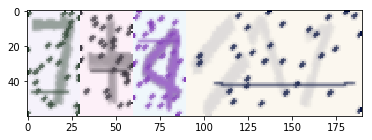

In [3]:
captcha1 = image_captcha.generate('7')
captcha_image1 = Image.open(captcha1)
arr1 = np.array(captcha_image1)

captcha_op = image_captcha.generate('+')
captcha_image_op = Image.open(captcha_op)
arr_op = np.array(captcha_image_op)

captcha2 = image_captcha.generate('4')
captcha_image2 = Image.open(captcha2)
arr2 = np.array(captcha_image2)

answer = image_captcha_answer.generate('=11')
captcha_answer = Image.open(answer)
arr_answer = np.array(captcha_answer)

arr = np.hstack((arr1, arr_op, arr2, arr_answer))
print('shape:', arr.shape)
plt.imshow(arr)
plt.show()

主要思路是将`7`、`+`和`4`的图像最为输入来训练模型，使模型能够正确识别数字与操作符，进行运算返回正确答案

作为示例，为了简化计算，我们的输入数字限定为0到9，输入的操作符号限定为`+`、`-`、`*`和`/`

In [4]:
# 数字范围
DIGIT_RANGE = np.arange(10)
DIGIT_SIZE = DIGIT_RANGE.size

# 操作符号范围
OPS_RANGE = ['+', '-', '*', '/']
OPS_SIZE = len(OPS_RANGE)

# 将操作符号编码
OPS_TO_INDEX = {op:i for i, op in enumerate(OPS_RANGE)}
INDEX_TO_OPS = {i:op for op, i in OPS_TO_INDEX.items()}

INDEX_TO_OPS, OPS_TO_INDEX

({0: '+', 1: '-', 2: '*', 3: '/'}, {'*': 2, '+': 0, '-': 1, '/': 3})

将数字和操作符的标签(label)进行编码，转为one-hot形式

In [5]:
# 编码数字标签
def encode_number_label(num_label):
    label_encoded = np.zeros((len(num_label), DIGIT_SIZE), dtype=np.int8)
    for i, num in enumerate(num_label):
        label_encoded[i, num] = 1
    return label_encoded

# 解码数字标签
def decode_numer_label(num_label_vector):
    labels = []
    for vec in num_label_vector:
        index = np.argmax(vec)
        labels.append(index)
    return labels

# 编码操作符标签
def encode_ops_label(ops_label):
    label_encoded = np.zeros((len(ops_label), OPS_SIZE), dtype=np.int8)
    for i, op in enumerate(ops_label):
        label_encoded[i, OPS_TO_INDEX[op]] = 1
    return label_encoded

# 解码操作符标签
def decode_ops_label(ops_label_vector):
    labels = []
    for vec in ops_label_vector:
        index = np.argmax(vec)
        labels.append(INDEX_TO_OPS[index])
    return labels

定义生成器来批量产生图像数据和其标签

In [6]:
# 返回指定的图像
def get_img_arr(img_str):
    captcha = image_captcha.generate(img_str)
    captcha_image = Image.open(captcha)
    arr = np.array(captcha_image)
    # 将R、G、B的值转换到0-1之间
    arr = arr / 255
    return arr

# 数字图像生成器
def generate_num_data(batch_size=128):
    while True:
        X = np.zeros((batch_size, HEIGHT, WIDTH, 3)) 
        y_label = []
        nums = np.random.randint(10, size=batch_size)
        for i, num in enumerate(nums):
            y_label.append(num)
            img_str = str(num)
            X[i] = get_img_arr(img_str)
        y_label_encoded = encode_number_label(y_label)
        yield X, y_label_encoded
        
# 符号图像生成器        
def generate_ops_data(batch_size=128):
    while True:
        X = np.zeros((batch_size, HEIGHT, WIDTH, 3))
        y_label = []
        ops = np.random.choice(OPS_RANGE, size=batch_size)
        for i, op in enumerate(ops):
            y_label.append(op)
            X[i] = get_img_arr(op)
        y_label_encoded = encode_ops_label(y_label)
        yield X, y_label_encoded

测试我们定义的生成器

(16, 60, 30, 3)


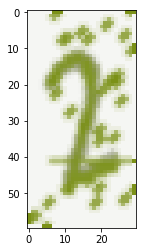

num:  2


In [7]:
test_num_generate = generate_num_data(16)
for X, y in test_num_generate:
    print(X.shape)
    plt.imshow(X[0])
    plt.show()
    print('num: ', decode_numer_label(y)[0])
    break

(16, 60, 30, 3)


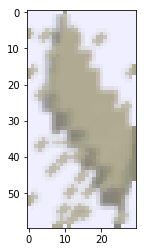

ops:  -


In [8]:
test_ops_generate = generate_ops_data(16)
for X, y in test_ops_generate:
    print(X.shape)
    plt.imshow(X[0])
    plt.show()
    print('ops: ', decode_ops_label(y)[0])
    break

## 训练卷积网络模型

作为示例，这里分别对数字图像和操作符图像构建两个VGG-Like的卷积网络模型

In [9]:
from keras import layers
from keras.models import Model
from keras.callbacks import TensorBoard
import time

D:\Coding\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [10]:
# 定义3个卷积层
conv_layer_num = 3

- 数字模型

In [11]:
inputs = layers.Input(shape=(HEIGHT, WIDTH, 3))

x = inputs
for i in range(conv_layer_num):
    x = layers.Conv2D(32 * 2 ** i, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(32 * 2 ** i, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPool2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)
    
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)

outputs = layers.Dense(DIGIT_SIZE, activation='softmax')(x)

num_model = Model(inputs=inputs, outputs=outputs)

In [12]:
num_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

训练数字模型

In [13]:
tensorboard = TensorBoard(log_dir='models/num_%s' % time.strftime('%Y-%m-%d_%H-%M-%S'), write_graph=True)

num_model.fit_generator(generate_num_data(), steps_per_epoch=128, epochs=30, 
                        validation_data=generate_num_data(), validation_steps=10, 
                        callbacks=[tensorboard], verbose=0)

测试数字模型

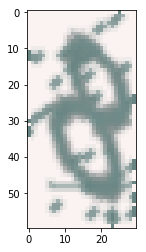

predict num:  8


In [14]:
captcha_num = image_captcha.generate('8')
captcha_num_image = Image.open(captcha_num)
arr = np.array(captcha_num_image)

y = num_model.predict(arr[np.newaxis, ...])

plt.imshow(arr)
plt.show()
print('predict num: ', decode_numer_label(y)[0])

- 操作符模型

In [15]:
inputs = layers.Input(shape=(HEIGHT, WIDTH, 3))

x = inputs
for i in range(conv_layer_num):
    x = layers.Conv2D(32 * 2 ** i, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(32 * 2 ** i, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPool2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)
    
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)

outputs = layers.Dense(OPS_SIZE, activation='softmax')(x)

ops_model = Model(inputs=inputs, outputs=outputs)

In [16]:
ops_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

训练操作符模型

In [17]:
tensorboard = TensorBoard(log_dir='models/ops_%s' % time.strftime('%Y-%m-%d_%H-%M-%S'), write_graph=True)

ops_model.fit_generator(generate_ops_data(), steps_per_epoch=128, epochs=30, 
                        validation_data=generate_ops_data(), validation_steps=10, 
                        callbacks=[tensorboard], verbose=0)

测试操作符识别模型

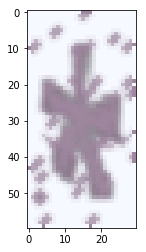

predict num:  *


In [18]:
captcha_op = image_captcha.generate('*')
captcha_op_image = Image.open(captcha_op)
arr = np.array(captcha_op_image)

y = ops_model.predict(arr[np.newaxis, ...])

plt.imshow(arr)
plt.show()
print('predict num: ', decode_ops_label(y)[0])

## 测试模型

生成2张数字图像和1张操作符图像来测试一下我们的模型

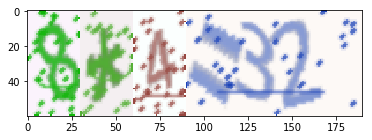

predict:  8 * 4 =32


In [20]:
# 计算函数
def cal_num_op(num1, op, num2):
    num1 = int(num1)
    num2 = int(num2)
    if op == '+':
        res = num1 + num2
    elif op == '-':
        res = num1 - num2
    elif op == '*':
        res = num1 * num2
    else:
        res = round(num1 / num2, 1)
    return str(res)

# 生成第一个数字图像
captcha1 = image_captcha.generate('8')
captcha_image1 = Image.open(captcha1)
arr1 = np.array(captcha_image1)
pred_num1 = num_model.predict(arr1[np.newaxis, ...])
pred_num1 = decode_numer_label(pred_num1)[0]

# 生成操作符图像
captcha_op = image_captcha.generate('*')
captcha_image_op = Image.open(captcha_op)
arr_op = np.array(captcha_image_op)
pred_op = ops_model.predict(arr_op[np.newaxis, ...])
pred_op = decode_ops_label(pred_op)[0]

# 生成第二个数字图像
captcha2 = image_captcha.generate('4')
captcha_image2 = Image.open(captcha2)
arr2 = np.array(captcha_image2)
pred_num2 = num_model.predict(arr2[np.newaxis, ...])
pred_num2 = decode_numer_label(pred_num2)[0]

# 根据预测计算最终的输出结果
answer_str = '=' + cal_num_op(pred_num1, pred_op, pred_num2)
answer = image_captcha_answer.generate(answer_str)
captcha_answer = Image.open(answer)
arr_answer = np.array(captcha_answer)

arr = np.hstack((arr1, arr_op, arr2, arr_answer))
plt.imshow(arr)
plt.show()
print('predict: ', '8 * 4', answer_str)